Importing Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier

In [2]:
df=pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Removing Outliers from amount feature

<Axes: >

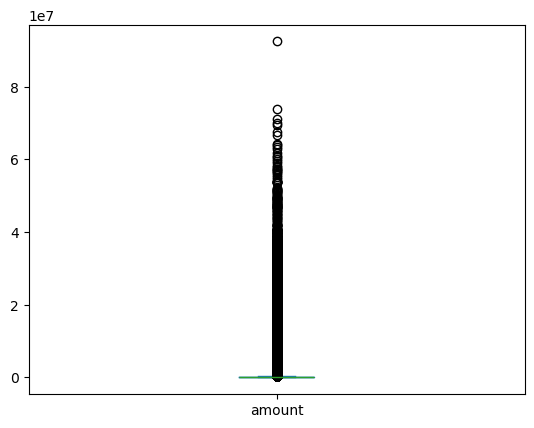

In [3]:
df.amount.plot(kind='box')

In [4]:
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1

data = df[~((df['amount'] < (Q1 - 1.5 * IQR)) | (df['amount'] > (Q3 + 1.5 * IQR)))]
data.shape

(6024542, 11)

<Axes: >

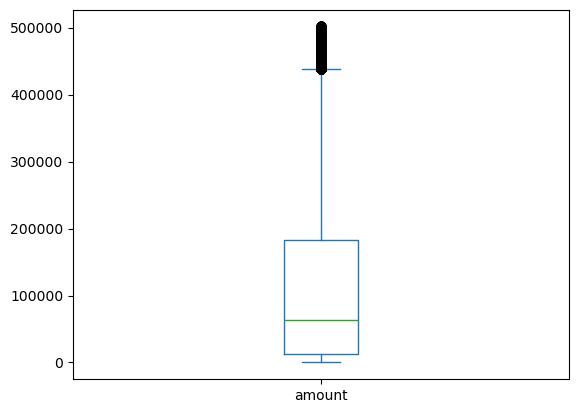

In [5]:
data.amount.plot(kind='box')

In [6]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
data.duplicated().sum()

0

In [8]:
data.isFraud.value_counts()

isFraud
0    6020183
1       4359
Name: count, dtype: int64

Data is highly IMBALANCED ,

Method 1 : Undersampling the Majority Class

In [9]:
#Manually undersampling
fraud=data[data.isFraud==1]
notfraud=data[data.isFraud==0]

In [10]:
len(notfraud)

6020183

In [11]:
notfraud2=notfraud.sample(4359)
len(notfraud2)

4359

In [12]:
newdf=pd.concat((fraud,notfraud2),axis=0)
newdf.reset_index(inplace=True)
newdf

,index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
1,3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
2,251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
3,252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
4,680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8713,5028038,353,CASH_OUT,198608.19,C1313072103,0.00,0.0,C797595710,806089.95,1004698.14,0,0
8714,4981979,352,CASH_IN,121374.94,C1507420722,4764913.76,4886288.7,C1185563966,491379.31,370004.37,0,0
8715,6154396,547,CASH_OUT,70093.82,C1494367021,0.00,0.0,C1166468461,197881.91,267975.73,0,0
8716,5619331,395,CASH_OUT,325981.50,C23240441,0.00,0.0,C717928322,8225973.79,8551955.29,0,0


In [13]:
newdf.isFraud.value_counts()

isFraud
1    4359
0    4359
Name: count, dtype: int64

In [14]:
dummies=pd.get_dummies(newdf['type'],drop_first=True)
dummies

,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,False,False,False,True
1,True,False,False,False
2,False,False,False,True
3,True,False,False,False
4,False,False,False,True
...,...,...,...,...
8713,True,False,False,False
8714,False,False,False,False
8715,True,False,False,False
8716,True,False,False,False


In [15]:
newData=pd.concat((newdf,dummies),axis=1)

In [16]:
#Using domain knowledge we will select all columns except 'nameOrig','nameDest'and 'isFlaggedFraud' as they dont contribute much in model training and prediction

In [17]:
newData.drop(['type','nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)

In [18]:
newData

,index,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,2,1,181.00,181.00,0.0,0.00,0.00,1,False,False,False,True
1,3,1,181.00,181.00,0.0,21182.00,0.00,1,True,False,False,False
2,251,1,2806.00,2806.00,0.0,0.00,0.00,1,False,False,False,True
3,252,1,2806.00,2806.00,0.0,26202.00,0.00,1,True,False,False,False
4,680,1,20128.00,20128.00,0.0,0.00,0.00,1,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
8713,5028038,353,198608.19,0.00,0.0,806089.95,1004698.14,0,True,False,False,False
8714,4981979,352,121374.94,4764913.76,4886288.7,491379.31,370004.37,0,False,False,False,False
8715,6154396,547,70093.82,0.00,0.0,197881.91,267975.73,0,True,False,False,False
8716,5619331,395,325981.50,0.00,0.0,8225973.79,8551955.29,0,True,False,False,False


In [19]:
X = newData.drop(['isFraud'], axis=1)
y = newData['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
X_train_scaled

array([[-1.12461831, -0.84848912,  2.06254892, ..., -0.05876546,
        -0.4785426 , -0.60802711],
       [-0.96797903, -0.74091895, -0.11931477, ..., -0.05876546,
        -0.4785426 , -0.60802711],
       [-0.37423884, -0.38235169, -0.58656885, ..., -0.05876546,
        -0.4785426 , -0.60802711],
       ...,
       [-0.61542878, -0.52065621, -0.64538415, ..., -0.05876546,
        -0.4785426 , -0.60802711],
       [ 1.22590461,  1.49756519, -0.98501284, ..., -0.05876546,
         2.08967811, -0.60802711],
       [-1.12228425, -0.84848912, -0.71212404, ..., -0.05876546,
        -0.4785426 , -0.60802711]])

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
model = Sequential()
model.add(Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), 
                    epochs=50, batch_size=256)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6537 - loss: 0.6277 - val_accuracy: 0.7519 - val_loss: 0.5129
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7501 - loss: 0.5121 - val_accuracy: 0.7978 - val_loss: 0.4168
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7814 - loss: 0.4378 - val_accuracy: 0.8070 - val_loss: 0.3668
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8002 - loss: 0.3981 - val_accuracy: 0.8104 - val_loss: 0.3449
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8039 - loss: 0.3832 - val_accuracy: 0.8150 - val_loss: 0.3323
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8147 - loss: 0.3555 - val_accuracy: 0.8276 - val_loss: 0.3209
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8239 - loss: 0.3549 - val_accuracy: 0.8291 - val_loss: 0.3146
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8108 - loss: 0.3466 - val_accuracy: 0.8410 - val_loss

In [26]:
y_pred=model.predict(X_test)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [27]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.36      0.51      1308
           1       0.59      0.93      0.72      1308

    accuracy                           0.64      2616
   macro avg       0.71      0.64      0.61      2616
weighted avg       0.71      0.64      0.61      2616

[[ 476  832]
 [  97 1211]]


In [28]:
#We can use feature importance method of RandomForestClassifier to find importance features which are contributing in ML model training and prediction

In [29]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [30]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                importance
oldbalanceOrg     0.249237
newbalanceOrig    0.167863
TRANSFER          0.124179
PAYMENT           0.089487
amount            0.073584
newbalanceDest    0.068856
index             0.061207
CASH_OUT          0.056335
oldbalanceDest    0.055196
step              0.053639
DEBIT             0.000416


The key factors that predict fraudulent customer:

Amount: Unusually large transactions may indicate fraud.

Old Balance: Significant changes before transactions could signal fraud.

New Balance: Unexpected changes post-transaction may suggest fraud.

Transaction Type: Certain types may be associated with fraudulent activity.

Step

In [31]:
# Undersampling the Majority Class Using RandomUnderSampler

In [32]:
data1=data.copy()
data1['type'] = LabelEncoder().fit_transform(data1['type'])
data1.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

In [33]:
data1.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1
3,1,1,181.00,181.0,0.00,21182.0,0.0,1
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0


In [34]:
X = data1.drop(['isFraud'], axis=1)
y = data1['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

In [35]:
print(f"Original dataset shape: {y_train.value_counts()}")
print(f"Resampled dataset shape: {y_res.value_counts()}")

Original dataset shape: isFraud
0    4214128
1       3051
Name: count, dtype: int64
Resampled dataset shape: isFraud
0    3051
1    3051
Name: count, dtype: int64


In [36]:
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)

In [37]:
model0 = Sequential()
model0.add(Dense(32, input_dim=X_train_res_scaled.shape[1], activation='relu'))
model0.add(Dropout(0.2))
model0.add(Dense(16, activation='relu'))
model0.add(Dropout(0.2))
model0.add(Dense(8, activation='relu'))
model0.add(Dense(1, activation='sigmoid'))
model0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
history0 = model0.fit(X_train_res_scaled, y_res, validation_data=(X_test_scaled, y_test), 
                    epochs=25)
#we can use more epochs for better training

Epoch 1/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 48s 229ms/step - accuracy: 0.5883 - loss: 0.6451 - val_accuracy: 0.8589 - val_loss: 0.4792
Epoch 2/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 45s 236ms/step - accuracy: 0.7777 - loss: 0.4905 - val_accuracy: 0.9057 - val_loss: 0.4273
Epoch 3/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 218ms/step - accuracy: 0.8022 - loss: 0.4403 - val_accuracy: 0.9136 - val_loss: 0.3919
Epoch 4/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 83s 222ms/step - accuracy: 0.8051 - loss: 0.4229 - val_accuracy: 0.9125 - val_loss: 0.3930
Epoch 5/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 43s 227ms/step - accuracy: 0.8171 - loss: 0.3965 - val_accuracy: 0.9150 - val_loss: 0.3655
Epoch 6/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 214ms/step - accuracy: 0.8206 - loss: 0.3764 - val_accuracy: 0.9221 - val_loss: 0.3271
Epoch 7/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 43s 226ms/step - accuracy: 0.8315 - loss: 0.3676 - val_accuracy: 0.9012 - val_loss: 0.3496
Epoch 8/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 43s 228ms/step - accuracy: 0.8354 - loss: 0

In [39]:
y_pred=model0.predict(X_test)

56481/56481 ━━━━━━━━━━━━━━━━━━━━ 31s 551us/step


In [40]:
y_pred = (y_pred > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83   1806055
           1       0.00      1.00      0.00      1308

    accuracy                           0.71   1807363
   macro avg       0.50      0.85      0.42   1807363
weighted avg       1.00      0.71      0.83   1807363

[[1283495  522560]
 [      6    1302]]


Method 2 : Oversampling the Minority Class

In [41]:
data1=data.copy()

In [42]:
data1

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362609,742,CASH_OUT,258355.42,C1113162093,258355.42,0.00,C797688696,25176.67,283532.09,1,0
6362610,742,TRANSFER,63416.99,C778071008,63416.99,0.00,C1812552860,0.00,0.00,1,0
6362611,742,CASH_OUT,63416.99,C994950684,63416.99,0.00,C1662241365,276433.18,339850.17,1,0
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.00,C1850423904,0.00,0.00,1,0


In [43]:
data1.isFraud.value_counts()

isFraud
0    6020183
1       4359
Name: count, dtype: int64

In [44]:
data1['type'] = LabelEncoder().fit_transform(data1['type'])
data1

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,3,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,4,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,3,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362609,742,1,258355.42,C1113162093,258355.42,0.00,C797688696,25176.67,283532.09,1,0
6362610,742,4,63416.99,C778071008,63416.99,0.00,C1812552860,0.00,0.00,1,0
6362611,742,1,63416.99,C994950684,63416.99,0.00,C1662241365,276433.18,339850.17,1,0
6362614,743,4,339682.13,C2013999242,339682.13,0.00,C1850423904,0.00,0.00,1,0


In [45]:
data1.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

In [46]:
data1

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,3,9839.64,170136.00,160296.36,0.00,0.00,0
1,1,3,1864.28,21249.00,19384.72,0.00,0.00,0
2,1,4,181.00,181.00,0.00,0.00,0.00,1
3,1,1,181.00,181.00,0.00,21182.00,0.00,1
4,1,3,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...,...
6362609,742,1,258355.42,258355.42,0.00,25176.67,283532.09,1
6362610,742,4,63416.99,63416.99,0.00,0.00,0.00,1
6362611,742,1,63416.99,63416.99,0.00,276433.18,339850.17,1
6362614,743,4,339682.13,339682.13,0.00,0.00,0.00,1


In [47]:
X = data1.drop(['isFraud'], axis=1)
y = data1['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [48]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [49]:
print(f"Original dataset shape: {y_train.value_counts()}")
print(f"Resampled dataset shape: {y_train_res.value_counts()}")

Original dataset shape: isFraud
0    4214128
1       3051
Name: count, dtype: int64
Resampled dataset shape: isFraud
0    4214128
1    4214128
Name: count, dtype: int64


In [50]:
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [51]:
model1 = Sequential()
model1.add(Dense(32, input_dim=X_train_res_scaled.shape[1], activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

In [52]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
history1 = model1.fit(X_train_res_scaled, y_train_res, validation_data=(X_test_scaled, y_test), 
                    epochs=15)
#we can use more epochs for better training

Epoch 1/15
263383/263383 ━━━━━━━━━━━━━━━━━━━━ 324s 1ms/step - accuracy: 0.9670 - loss: 0.0944 - val_accuracy: 0.9856 - val_loss: 0.0426
Epoch 2/15
263383/263383 ━━━━━━━━━━━━━━━━━━━━ 338s 1ms/step - accuracy: 0.9833 - loss: 0.0566 - val_accuracy: 0.9886 - val_loss: 0.0402
Epoch 3/15
263383/263383 ━━━━━━━━━━━━━━━━━━━━ 377s 1ms/step - accuracy: 0.9849 - loss: 0.0521 - val_accuracy: 0.9855 - val_loss: 0.0452
Epoch 4/15
263383/263383 ━━━━━━━━━━━━━━━━━━━━ 494s 2ms/step - accuracy: 0.9857 - loss: 0.0498 - val_accuracy: 0.9891 - val_loss: 0.0346
Epoch 5/15
263383/263383 ━━━━━━━━━━━━━━━━━━━━ 580s 2ms/step - accuracy: 0.9865 - loss: 0.0473 - val_accuracy: 0.9897 - val_loss: 0.0361
Epoch 6/15
263383/263383 ━━━━━━━━━━━━━━━━━━━━ 557s 2ms/step - accuracy: 0.9870 - loss: 0.0458 - val_accuracy: 0.9889 - val_loss: 0.0391
Epoch 7/15
263383/263383 ━━━━━━━━━━━━━━━━━━━━ 688s 3ms/step - accuracy: 0.9874 - loss: 0.0442 - val_accuracy: 0.9917 - val_loss: 0.0324
Epoch 8/15
263383/263383 ━━━━━━━━━━━━━━━━━━━━ 68

In [54]:
y_pred=model1.predict(X_test_scaled)

56481/56481 ━━━━━━━━━━━━━━━━━━━━ 73s 1ms/step


In [55]:
y_pred = (y_pred > 0.5).astype("int32")

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1806055
           1       0.08      0.99      0.16      1308

    accuracy                           0.99   1807363
   macro avg       0.54      0.99      0.58   1807363
weighted avg       1.00      0.99      1.00   1807363



In [57]:
CM=confusion_matrix(y_test, y_pred)
print(CM)

[[1791987   14068]
 [      7    1301]]


 1.

98 % Accuracy on Test data

Imbalanced classification with extremely low minority class (1) precision despite good overall accuracy.

The high accuracy is primarily driven by the model's ability to correctly predict the majority class (0), 
while it struggles with the minority class (1) due to its rarity and low precision.

True negatives (1791987): Correctly predicted instances of class 0.

False positives (14068): Instances wrongly predicted as class 1 when they are actually class 0.

False negatives (7): Instances wrongly predicted as class 0 when they are actually class 1.

True positives (1301): Correctly predicted instances of class 1.

Preventions should be adopted while company update its infrastructure:
When updating infrastructure, companies should focus on preventing problems by adding extra security measures like multi-factor authentication,
encryption, and intrusion detection. They should control who has access to important information, keep software updated,
and have a plan for emergencies.

Fraud detection model using deep learning..................

Prepares Data: Collects, cleans, and normalizes transaction data.

Chooses Model: Sequential().

Balances Data: Applies SMOTE to handle class imbalance.

Trains Model: Train data using training data and test performance on test data.

Evaluates: Measures precision, recall, F1-score.